In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

In [3]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [4]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

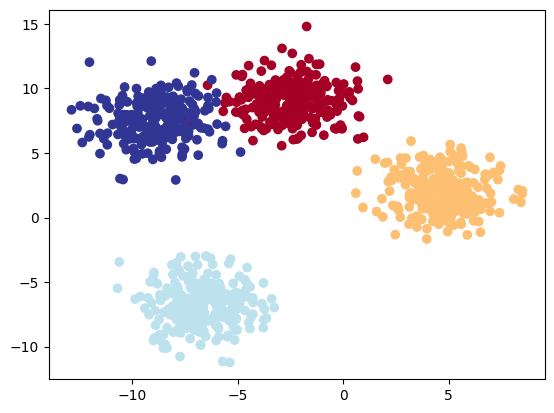

In [5]:
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [6]:
from torch import nn

class Multiclass(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model = Multiclass(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8)
model

Multiclass(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.1)

In [9]:
model(X_blob_train)[:5]

tensor([[-0.4108,  0.0876, -0.5264, -0.1540],
        [ 0.4877,  0.6093, -3.0425,  0.7394],
        [-0.7029, -0.4006,  0.2804, -0.1542],
        [-0.4614, -0.1699, -0.3926,  0.0035],
        [ 0.3387,  0.4834, -2.6266,  0.6271]], grad_fn=<SliceBackward0>)

In [10]:
model(X_blob_train)[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [13]:
y_logits = model(X_blob_test)

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.2963,  0.1660, -0.8465, -0.0511],
        [ 0.5529,  0.5516, -3.2284,  0.8913],
        [-0.7239, -0.3718,  0.3406, -0.2124],
        [-0.5122, -0.0154, -0.2440, -0.2147],
        [ 0.4105,  0.6007, -2.8249,  0.6296]], grad_fn=<SliceBackward0>)
tensor([[0.2251, 0.3574, 0.1298, 0.2876],
        [0.2920, 0.2917, 0.0067, 0.4096],
        [0.1431, 0.2035, 0.4148, 0.2386],
        [0.1888, 0.3102, 0.2468, 0.2542],
        [0.2862, 0.3462, 0.0113, 0.3563]], grad_fn=<SliceBackward0>)


In [14]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [15]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2251, 0.3574, 0.1298, 0.2876], grad_fn=<SelectBackward0>)
tensor(1)


In [17]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [19]:
torch.manual_seed(42)

# Set number of epochs
epochs = 100

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.11543, Acc: 57.38% | Test Loss: 0.66338, Test Acc: 93.00%
Epoch: 10 | Loss: 0.17945, Acc: 99.00% | Test Loss: 0.16240, Test Acc: 99.50%
Epoch: 20 | Loss: 0.09293, Acc: 99.12% | Test Loss: 0.08426, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06530, Acc: 99.12% | Test Loss: 0.05741, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05248, Acc: 99.12% | Test Loss: 0.04455, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04527, Acc: 99.12% | Test Loss: 0.03715, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04070, Acc: 99.12% | Test Loss: 0.03239, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03758, Acc: 99.12% | Test Loss: 0.02909, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03533, Acc: 99.12% | Test Loss: 0.02667, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03363, Acc: 99.12% | Test Loss: 0.02482, Test Acc: 99.50%


In [21]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  6.5763,  11.7583, -11.9889,  -6.9530],
        [  1.9856, -12.1798,  -0.0762,   7.5841],
        [-10.8449, -14.6607,  16.3607,   7.9240],
        [  2.9554,   8.5086,  -6.6831,  -5.2626],
        [  9.2851,   4.5652, -13.4398,  -2.1988],
        [  1.9571, -15.2472,   0.7616,   9.4997],
        [-10.5408, -11.3187,  15.1120,   5.8628],
        [  7.1330,   0.1207,  -9.6287,   0.3775],
        [-12.1135, -20.2944,  19.3958,  11.3275],
        [  7.7710,   1.7317, -10.8353,  -0.5697]])

In [22]:
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [23]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

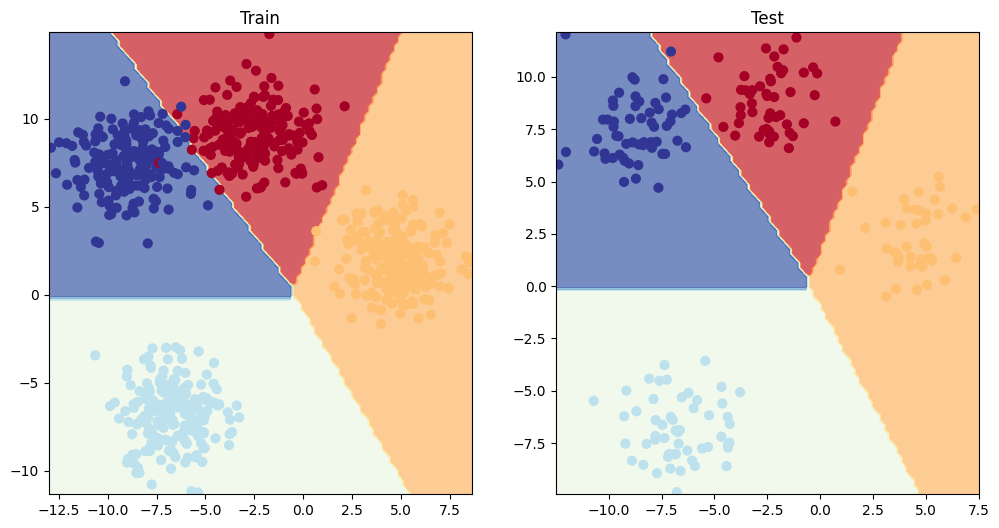

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

In [25]:
from torchvision import datasets
# load the training data
mnist_train = datasets.MNIST('data', train=True, download=True)
mnist_train = list(mnist_train)[:2500]
print(mnist_train[0])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:28<00:00, 353370.33it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 125864.81it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:04<00:00, 390017.57it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2272790.36it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

(<PIL.Image.Image image mode=L size=28x28 at 0x20298A3D910>, 5)


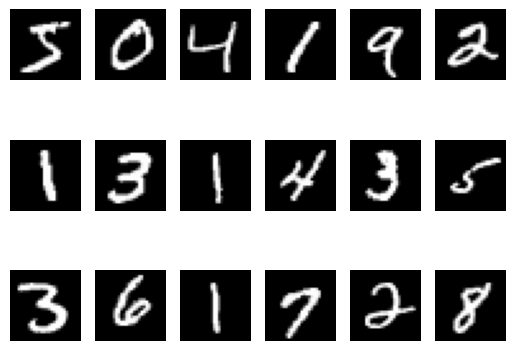

In [28]:
# plot the first 18 images in the training data
import matplotlib.pyplot as plt

for k, (image, label) in enumerate(mnist_train[:18]):
    plt.subplot(3, 6, k+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [29]:
from torchvision import transforms
# transform the image data type to a 28x28 matrix of numbers
img_to_tensor = transforms.ToTensor()


In [30]:
# convert the last image we saw into a tensor
img_tensor = img_to_tensor(image)
img_tensor.shape

torch.Size([1, 28, 28])

In [31]:
mnist_train = datasets.MNIST('data', train=True, transform=img_to_tensor)
mnist_train = list(mnist_train)[:2500]
print(mnist_train[0])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [32]:
mnist_train, mnist_val = mnist_train[:2000], mnist_train[2000:]

In [33]:
example_model = nn.Linear(50, 1) # assume 50 features, 1 linear output

weight, bias = list(example_model.parameters())
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[ 0.1081,  0.1174, -0.0331,  0.1299, -0.0310,  0.0285, -0.0689,  0.0831,
          0.1247, -0.1038,  0.1229,  0.0265,  0.1045,  0.0192,  0.0682, -0.0200,
          0.1090,  0.0209, -0.0660,  0.0360, -0.0652, -0.0166, -0.0574,  0.0938,
         -0.1116, -0.0652, -0.0399, -0.0850,  0.0133, -0.1397,  0.1277, -0.1201,
          0.1092,  0.0235, -0.0459,  0.0874,  0.0220,  0.1143,  0.0155, -0.0446,
          0.0380, -0.0384,  0.0595,  0.1263,  0.0817, -0.0618,  0.0816,  0.0253,
          0.0718, -0.0862]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([-0.1400], requires_grad=True)
torch.Size([1])


In [34]:
example_model = nn.Linear(50, 1)
weight, bias = list(example_model.parameters())
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[-0.0546, -0.1085,  0.1160,  0.0407,  0.0586,  0.0447, -0.0025,  0.1107,
         -0.1005,  0.0089, -0.0965,  0.0436, -0.0487,  0.0433, -0.0295,  0.1173,
         -0.0838, -0.0843, -0.0843,  0.1272,  0.0471,  0.1361, -0.1167, -0.1403,
         -0.1106, -0.0951,  0.0573,  0.0506,  0.1175, -0.0730, -0.0964,  0.0750,
         -0.0572,  0.0858, -0.0336,  0.0809, -0.1099, -0.0714,  0.0431,  0.0299,
         -0.0361,  0.0843,  0.0961, -0.1026, -0.0755,  0.1295, -0.0477, -0.0501,
         -0.1368, -0.0810]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([0.0353], requires_grad=True)
torch.Size([1])


In [35]:
model = nn.Linear(784, 10)

In [36]:
weight, bias = list(model.parameters())
print(weight.shape)
print(bias.shape)

torch.Size([10, 784])
torch.Size([10])


In [37]:
x = torch.randn(50) # create a rank 1 tensor (vector) with 50 features
x.shape

torch.Size([50])

In [38]:
y = example_model(x)
y.shape

torch.Size([1])

In [39]:
torch.sigmoid(example_model(x))

tensor([0.3864], grad_fn=<SigmoidBackward0>)

In [40]:
x = torch.randn([32, 50]) # a stack of 32 inputs
print(x.shape)
y = example_model(x)
print(y.shape)

torch.Size([32, 50])
torch.Size([32, 1])


In [41]:
img_tensor.shape

torch.Size([1, 28, 28])

In [42]:
x = img_tensor.view(1, 784)
print(x.shape)
z = model(x)
print(z)
print(z.shape)
y = torch.softmax(z, dim=1)
print(y)


torch.Size([1, 784])
tensor([[-0.2552,  0.2884, -0.0502, -0.1298, -0.3552,  0.0051,  0.4625, -0.1692,
          0.1825,  0.1915]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])
tensor([[0.0739, 0.1272, 0.0907, 0.0837, 0.0668, 0.0958, 0.1514, 0.0805, 0.1144,
         0.1155]], grad_fn=<SoftmaxBackward0>)


: 